# QICK-DAWG Demo Notebook

This notebook is our demo for QICK-DAWG.  Our instrumentaiton setup, used for this notebook, is an RFSoC4x2 modified as shown in the demo. Additional setup includes:

- Our microwave output is connected to QICK channel 0, to a microwave amplifier, then to a PCB patterned to have a loop. 
- Our readout is a photodiode, connected to a variable attunuator, which is then connected to our differential amplifier input to QICK. (in later versions we will update the firmware and demonstrate how to switch to photon counting mode)
- Our laser is gated by PMOD channel 0 which is connected to a minicircuits microwave switch, which gates an AOM power supply.  (We have also tested this notebook by directly gating a fast current supply photodoide)

In the following three cells, we check that qick dawg is installed via 'pip install <path-to-qickdawg>', imports qickdawg, and starts the qick-dawg client. 

In [3]:
# If setup.py installed, run this to show version of qickdawg installed
!pip show qickdawg

Name: qickdawg
Version: 0.0.0
Summary: Software for full quantum control of nitrogen-vacancy defects and other quantum defects in diamond
Home-page: 
Author: 
Author-email: Andy Mounce <amounce@sandia.gov>, Emmeline Riendeau <eriendeau@uchicago.edu>
License: MIT License 

Copyright 2023 National Technology & Engineering Solutions of Sandia, LLC (NTESS). Under the terms of Contract DE-NA0003525 with NTESS, the U.S. Government retains certain rights in this software.

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substa

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

import qickdawg as qd

from scipy.optimize import curve_fit


In [9]:
qd.start_client('192.168.1.105')

min_step_us = qd.soccfg.cycles2us(1) # this is the minimum step size in us, which is the time for one clock cycle
min_step_ns = min_step_us*1e3
max_int_time_us = min_step_us * (2**16 - 1)
max_int_time_ns = min_step_ns * (2**16 - 1)

print(qd.soccfg)


QICK configuration:

	Board: RFSoC4x2

	Global clocks (MHz): tProcessor 409.600, RF reference 409.600

	2 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 0, blk 0, 32-bit DDS, fabric=409.600 MHz, f_dds=6553.600 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=409.600 MHz, f_dds=6553.600 MHz

	2 readout channels:
	0:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, blk 0, 32-bit DDS, fabric=409.600 MHz, fs=3276.800 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 4, tProc input 0
	1:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, blk 1, 32-bit DDS, fabric=409.600 MHz, fs=3276.800 MHz
		maxlen 1024 (avg) 16384 (decimated), trigger bit 5, tProc input 1

	2 DACs:
		DAC tile 0, blk 0 is DAC_B
		DAC tile 2, blk 0 is DAC_A

	2 ADCs:
		ADC tile 0, blk 0 is ADC_D
		ADC tile 0, blk 1 is ADC_C

	4 digital output pins (tProc output 7):
	0:	PMOD0_0
	1:	PMOD0_1


# Table of Contents
0. [Assgin default configurations for pulsing](#first-bullet)<br>
    a. The NVConfiguration object<br>
    b. A note about NVConfiguration<br>
1. [Turning your laser On and Off](#second-bullet) <br>
    a. Turn Your Laser On <br>
    b. Turn Your Laser Off <br>
2. [Photoluminescence (PL) Intensity](#third-bullet)<br>
    a. Plotting the Sequence <br>
    b. Configuration and Getting a Single Data Point of PL intensity<br>
    c. Plotting the Sequence with Attribute Values<br>
    d. PL Intensitiy Live<br>
3. [Optically Deteceted Magnetic Resonance (ODMR) Spectrum](#fourth-bullet)<br>
    a. Configuration, Measurment and Plotting<br>
    b. Live plot ODMR spectrum<br>
    c. Print the Assembly Language<br>
4. [Get the Readout Window](#fifth-bullet)<br>
    a. Configuration, Measurement, and Plotting<br>
    b. Fitting the Readout Window
5. [Rabi Oscillations](#seventh-bullet) <br>
    a. Configuration, Measurement, and Plotting <br>
    b. Fitting Rabi Oscillations <br>
    c. Live Rabi Oscillations <br>
6. [Ramsey](#sixth-bullet)<br>
    a. Configuration, Measurement, and Plotting<br>
    b. ODMR spectrum from Ramsey <br>
7. [Hahn Echo Delay Sweep](#eigth-bullet)<br>
    a. Configurations <br>
    b. Fitting Hahn Echo Decay, Getting T<sub>2 Hahn</sub><br>
8. [T<sub>1</sub> Delay Sweep](#nineth-bullet)<br>
    a. Configuration<br>
    b. Fitting T1 Decay, Getting T<sub>1</sub><br>

# 0. Assigning Default Configurations for Pulsing: NVConfiguration <a class="anchor" id="first-bullet"></a>
These are standard settings used across most, if not all, qickdawg programs <br>
Commonly used attributes:
- adc_channel: 0 or 1 and should be DC coupled through a differential amplifier (adc_channel = 0 if following Readme)
- mw_channel: microwave exciation channel, can be 0 or 1 for RFSoC4x2 or 0 to 6 for ZCU111 & ZCU216
- mw_nqz: Nyquist zone for the microwave generator. 1 for f < fdss/2 and 2 for f> fdss/2 
- mw_gain: Effectively mw amplitude.  From 0 to 2e15-1, i.e. 32767
- laser_gate_pmod: PMOD channel used to gate the laser on/off
- relax_delay_t#: delay time at the end of a pulse sequence, typically 500ns is sufficient


In [10]:
default_config = qd.NVConfiguration()

default_config.adc_channel = 0 
default_config.adc_trigger_offset_treg = 177

default_config.mw_channel = 0
default_config.mw_nqz = 1
default_config.mw_gain = 5000

default_config.laser_gate_pmod = 0

default_config.relax_delay_tns = 500 # between each rep, wait for everything to catch up, mostly aom


In [11]:
default_config.mw_gain

5000

## 0a. Units with NVConfiguration 

Attributes that have time, frequency, and phase units used by the qickdawg program have special syntax within NVConfiguration.<br>

Time units can be declared as a variable name with a suffix "_tns", "_tus", or "_treg" indicating **time** in units of nanoseconds, microseconds, or register values.  These values are automatically converted to one another when assigned as part of the .NVConfiguration object.  For example, assiging `default_config.relax_delay_treg = 500 ` immediately assigns `default_config.relax_delay_tus = 1.220703125` and `default_config.relax_delay_tns = 1220.703125`.  This allows the qickdawg user to input units of their choice and will automatically have the register values available for the qickdawg program to use. "_treg" values will be converted to integers if not given as an int. See examples below. <br>

Similarly frequency units can be declared with suffixes "_fMHz", "_fGHz", or "_freg".<br>
Phase units can be declared with suffixes "_pdegrees" or "_preg".


In [12]:
# Example:
default_config.relax_delay_treg, default_config.relax_delay_tus, default_config.relax_delay_tns

(205, 0.50048828125, 500.48828125)

### 0b. A note about NVConfiguration

NV configuration is a sublcass of ItemAttribute where you can access attributes of the class with typical attribute access, i.e. `object.attribute` or with dictionary like access `object['attribute']`. This is done to simplify the use of python classes.

In [13]:
# Example:
default_config['relax_delay_treg'], default_config.relax_delay_treg

(205, 205)

# 1. Turn Laser On and Off

These are simple but important classes/functions. Here we can turn our laser on or off with separate commands.  This allows you to test that the laser gating is acutally working or to set your laser into a mode which it can be used for alignment.  No new configuration attributes are required. 

## 1a. Turn your laser on

Sets the laser_gate_pmod to its high value without turning off. This qickdawg.laser_on also returns the average ADC value for the duration of the "on" time.  The default is 65655 register values. which is approximately 100us.

In [8]:
qd.laser_on(default_config)

271.7098039215686

## 1b. Turn Laser off

The opposite of laser_on.  qickdawg.laser_off is that turns the laser_gate_pmod to its low value thus turning the laser off. the output of this function is the average value read by the ADC when the laser is off. 

In [9]:
qd.laser_off(default_config)

397.6983138780804

# 2. Photoluminescence (PL) Intensity <a class="anchor" id="third-bullet"></a>

Here's where we actually start our "pulse sequencing". PL intensity is much like qd.LaserOn, but turns the laser off afterwards. The intent of this function is to not only get a value of photoluminescence intensity from the ADC, but also to also gather the PL intensity repeatedly and show live updated results for microscope alignment.

## 2a. Plotting the sequence
Most of our qickdawg programs also have a plot_sequence() which is intended to show the pulse sequence graphically both with and without the variable names/values. In the following cell we show how to plot the pulse sequence with configuration attribute names

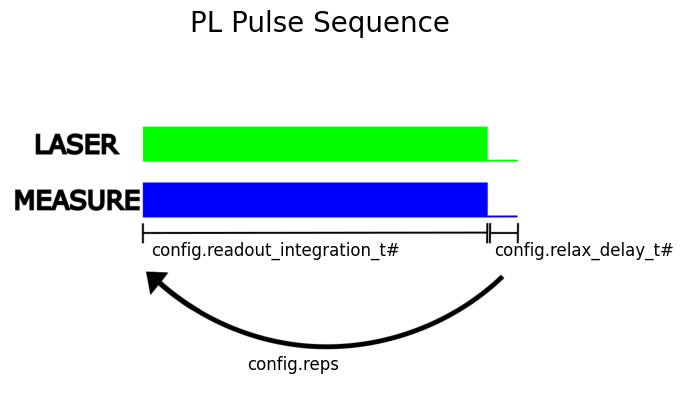

In [10]:
qd.PLIntensity.plot_sequence()

## 2b. Configuration and Getting a Single Data Point of PL Intensity

In [11]:
# Configuring settings 
config = copy(default_config)

config.readout_integration_treg = 2**16-1 # Maxium number of integrated points
config.reps = 500 

prog = qd.PLIntensity(config) 
prog.acquire()

385.71296867322803

## 2c. Plotting the Sequence with Attribute Values

In the next cell we show how to plot the sequence with the variable values, by simply passing the NVConfiguration instance to the plot_sequence() class function

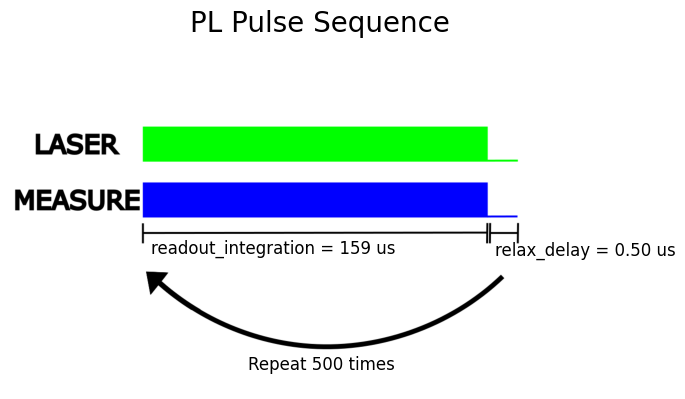

In [12]:
qd.PLIntensity.plot_sequence(config)

## 2d. PL Intensity Live

By making a lambda function that returns the PL intensity and using our qickdawg.live_plot function we can repeatedly measure the PL intensity and show the value on an updated plot. This is extremely useful for maximizing PL intensity while aligning your microscope. To exit, stop the currently executing cell using your JupyterNotebook server or press 'CTRL+C'

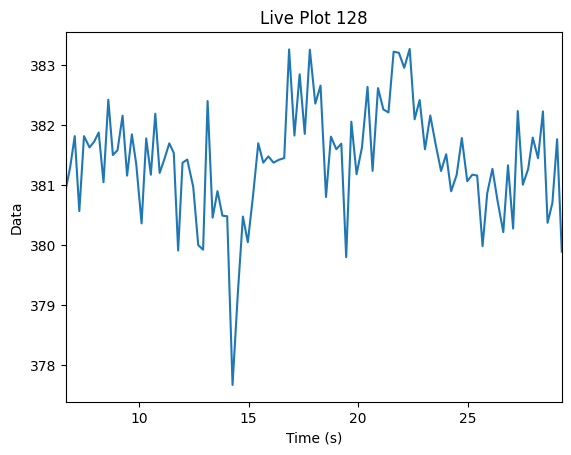

In [13]:
func = lambda : prog.acquire(progress=False)

qd.live_plot(func)

# 3 Optically detected magnetic resonance spectrum <a class="anchor" id="fourth-bullet"></a>

This qickdawg program is our first example of a "sweep", which performs a measurement while changing an experimental parameter. In this case, we make two measurements of photoluminescence one with our microwave output on and one with our output off.  The microwave frequency is the swept and we obtain an ODMR spectrum.

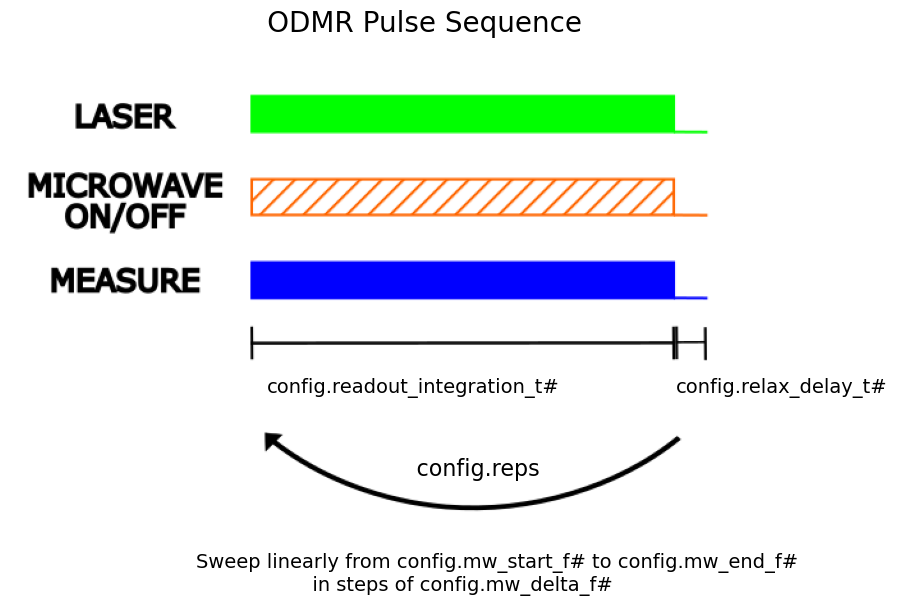

In [ ]:
qd.LockinODMR.plot_sequence()

## 3a. Configuration, Measurement, and Plotting

The program we are configuring, qd.LockODMR, uses the default configurations attributes and the following attributes which are new or changed from the default. 
- readout_integration_t#: integration and pulse duration
- mw_gain (int): repeated from default, but useful to change here
- pre_init (bool): true = initialize the spin state with a preliminary laser pulse, false = no preliminary initialization laser pulse 
- reps (int): number of times to repeat the frequency sweep

config.add_linear_sweep takes arguments that handle the following required attributes
- mw_start_freg: starting microwave frequency in register units 
- mw_end_freg: end microwave frequency in register units
- nsweep_points: number of frequency points between mw_start_f# and mw_end_f# 

Once our configurations are complete, we pass the config object to qd.LockinODMR, making an instance of the LockinODMR program.  Then we perform the measurement through the prog.acquire() method which returns a datastructure containing the analyzed results of the measurement. For qd.LockinODMR() this data structure includes

- .frequencies: the frequencies swept over
- .signal: PL intensity with the microwave output on
- .reference: PL intensity with the microwave output off
- .odmr: reference-signal
- .odmr_contrast: (reference-signal)/reference * 100%

In [ ]:
config = copy(default_config)

config.readout_integration_tus = max_int_time_us

config.mw_gain = 1000

config.pre_init = True 
config.reps = 10
config.relax_delay_treg = 500

config.add_linear_sweep('mw', 'fMHz', start=2400, stop=3000, delta=1)

prog = qd.LockinODMR(config)
d = prog.acquire()


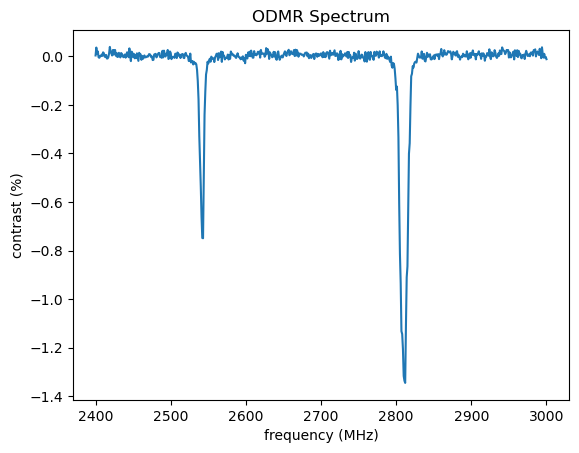

In [ ]:
plt.plot(d.frequencies, d.odmr_contrast)

plt.title('ODMR Spectrum')
plt.ylabel('contrast (%)')
plt.xlabel('frequency (MHz)')

plt.show()

[2811. 2808. 2542.]


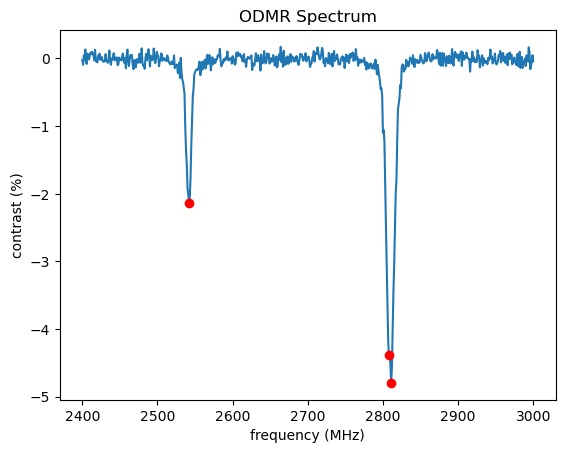

In [ ]:
# fit to find peak value
num_peaks=3
def find_peaks(signal):
    # Find peaks using a simple NumPy-based approach
    peaks = np.where((signal[:-2] < signal[1:-1]) & (signal[1:-1] > signal[2:]))[0] + 1
    sorted_peaks = sorted(peaks, key=lambda p: d.odmr_contrast[p])
    peaks_corrected=sorted_peaks[:num_peaks]
    return peaks_corrected
peaks=find_peaks(-d.odmr_contrast)

plt.plot(d.frequencies, d.odmr_contrast)

plt.plot(d.frequencies[peaks], d.odmr_contrast[peaks], 'ro', label='Peaks')
plt.title('Signal with Peaks')
plt.title('ODMR Spectrum')
plt.ylabel('contrast (%)')
plt.xlabel('frequency (MHz)')

print(d.frequencies[peaks])



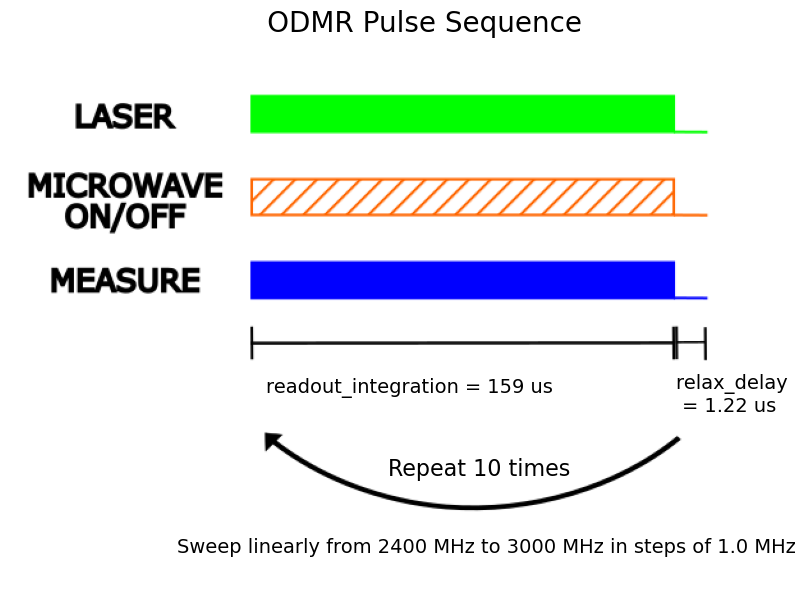

In [ ]:
# Plot the pulse sequence with attribute values
qd.LockinODMR.plot_sequence(config)

## 3b Live plot ODMR spectrum

Similarly to PLIntensity, we can also use `qickdawg.live_plot()` to repeatedly plot the ODMR spectrum.  This is particularly useful when manually adjusting magnetic field alignment.

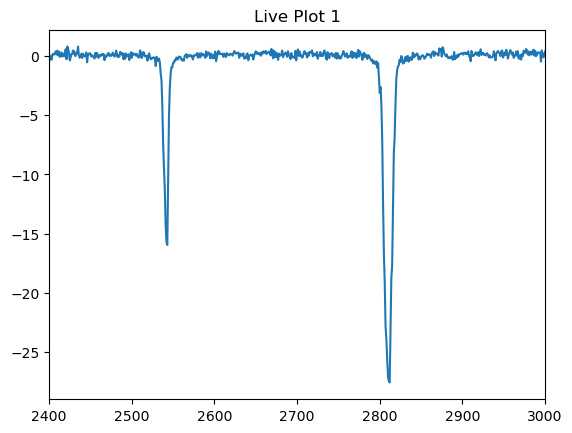

In [ ]:
def get_spectrum():
   d = prog.acquire()
   return d.frequencies, d.odmr

qd.live_plot(get_spectrum)

## 3c. Print the Assembly Language

Finally, we print out the assembly language generated by this pulse sequence program. Printing the associated assembly language is possible for all of the other programs but we'll leave it to the reader to print the assembly language for the other programs. 

In [ ]:
print(prog.asm())


// Program

                regwi 0, $21, 393216000;        //freq = 1572864000
                bitwi 0, $21, $21 << 2;
                regwi 0, $22, 0;                //phase = 0
                regwi 0, $24, 10000;            //gain = 10000
                regwi 0, $25, 655359;           //phrst| stdysel | mode | | outsel = 0b01001 | length = 65535 
                synci 400;
                regwi 0, $26, 0;                //t = 0
                set 0, 0, $21, $22, $0, $24, $25, $26;//ch = 0, pulse @t = $26
                regwi 0, $31, 1;                //out = 0b0000000000000001
                seti 7, 0, $31, 0;              //ch =0 out = $31 @t = 0
                seti 7, 0, $0, 65535;           //ch =0 out = 0 @t = 0
                synci 131570;
                regwi 0, $13, 0;
                regwi 0, $14, 9;
LOOP_rep:       regwi 0, $21, 393216000;        //'gen0_freq' <= 1572864000 (2400.0 MHz)
                bitwi 0, $21, $21 << 2;
                regwi 0, $15, 600;
LOOP

# 4. Calibrate the Readout Window <a class="anchor" id="fifth-bullet"></a>
The ODMR spectrum, obtained in the last pulse sequence, helps us determine the frequency of the NV transition which we wish to pulse on and will be assigned to the configuration config.mw_f#. With this frequency setting, we then calibrate our NV spin readout window.  Here we look for two parameters: the delay between triggering our laser source (which will be assigned to config.laser_readout_offset_t#) and the optimal reatodut integration time, which is given by the time constant for repumping the NVs into the ms=0 state. 

All of this is accomplished by qd.get_readout_window() which acquires time traces of PL with and without a microwave pulse. Due to initial memory limitations of QICK, we acquire time domain data over several time doimain windows which have a maximum size of ~1020 data points, spanning approximately 2.6 microseconds. Each window is acquired through a qd.ReadoutWindow() class which is generated and handled by the qd.get_readout_window function as shown below. 

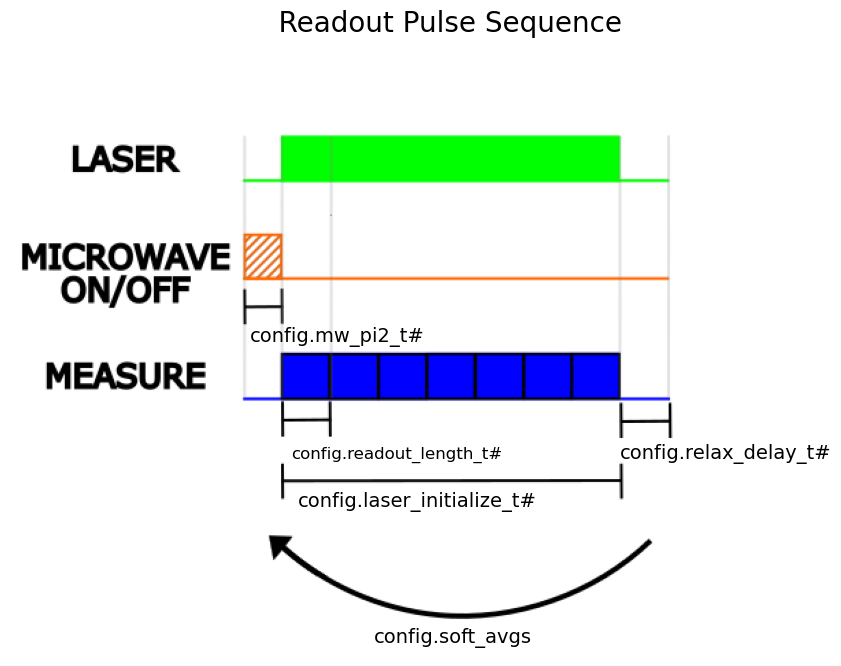

In [ ]:
qd.ReadoutWindow.plot_sequence()

## 4a. Configuration, Measurement, Plotting, and Fitting
The readout window pulse sequence requires the following new configuration attributes in addition to the default configuration:

- .mw_pi2_t# - approximate pi/2 pulse, used to give spin contrast in the readout window. 
- .mw_f# - pulsing frequency for the microwave channel

- .readout_length_t# - length of time series readout, tyipcally 1020 reg
- .laser_initialize_t# - total time for the laser to be on and should be sufficiently long to initilze spins to ms=0
- .mw_readout_delay_t# - buffer time between the end of the microwave pulse and the beginning of the readout, a few 100 ns is typically sufficient and depends on the experimental setup
- .laser_readout_offset_t# - time between the trigger of the laser and the beginning of the readout, as seen by the adc (to be calibrated in this sequence, initially set to 0)
- .soft_avgs - number of repititions to average over
- .reps = 1, time domain data can only be taken on rep at a time if the total readout length is 1020 points
- .pre_init = True, is extremely important for this sequence because the time between soft averages is sufficiently long that there is appreciable T1 relaxation and spins must be reinitialized before pulsing


In [ ]:
config = copy(default_config)

config.mw_gain = 30000

config.mw_pi2_treg = 150 # approximate pi/2 pulse in ns
config.mw_fMHz = 2540

config.relax_delay_tus = 1
config.readout_length_treg = 1020
config.laser_initialize_tus = 15 # in us

config.mw_readout_delay_treg= 50  #
config.laser_readout_offset_treg = 0 # <- Note this starts at 0 and we will change this based on the results
config.reps=1
config.soft_avgs = 1
config.rounds = 1200

config.pre_init=True

data_on, data_off, prog = qd.get_readout_window(config, n_time_bins=3)


0 0
1 1020
2 2040
0 0
1 1020
2 2040


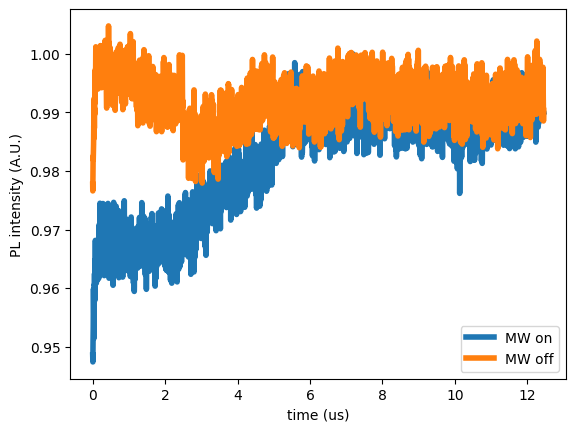

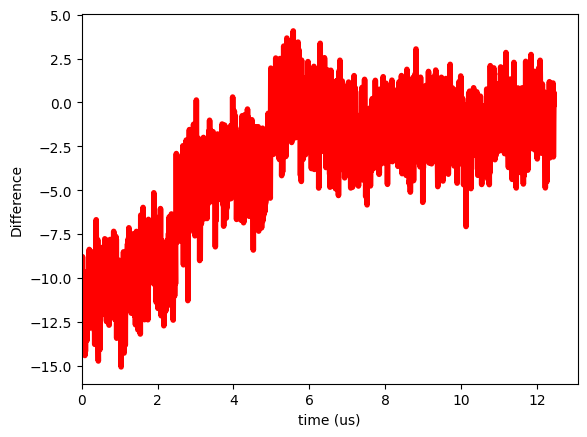

In [ ]:
# Here we plot the readout window data for the microwave pluse on and the microwave off

t = np.array(range(len(data_off))) * min_step_us
x = data_on
x2 = data_off

plt.plot(t, x/np.max(x), linewidth=4)
plt.plot(t, x2/np.max(x), linewidth=4) 

plt.legend(['MW on', 'MW off'])
plt.xlabel('time (us)')
plt.ylabel('PL intensity (A.U.)')
# plt.xlim(0, 190)
# plt.ylim(0, 1.1)
plt.show()

plt.plot(t, x - x2, c='red', linewidth=4)
plt.ylabel('Difference')
plt.xlabel('time (us)')
plt.xlim(0, )
plt.show()


In [ ]:
config = copy(default_config)

config.mw_gain = 30000

config.mw_pi2_treg = 150 # approximate pi/2 pulse in ns
config.mw_fMHz = 2540

config.relax_delay_tus = 1
config.readout_length_treg = 1020
config.laser_initialize_tus = 15 # in us

config.mw_readout_delay_treg=50  #
config.laser_readout_offset_treg = 310 # <- Now we've changed this so that the ADC starts collecting data at the beinnging of the window
                                       # laser_readout_offset_treg is the time needed to wait for the aom after triggering the laser to actually get a response
config.reps=1
config.soft_avgs = 1
config.rounds = 600

config.pre_init=True

data_on, data_off, prog = qd.get_readout_window(config, n_time_bins=5)


0 310
1 1330
2 2350
3 3370
4 4390
0 310
1 1330
2 2350
3 3370
4 4390


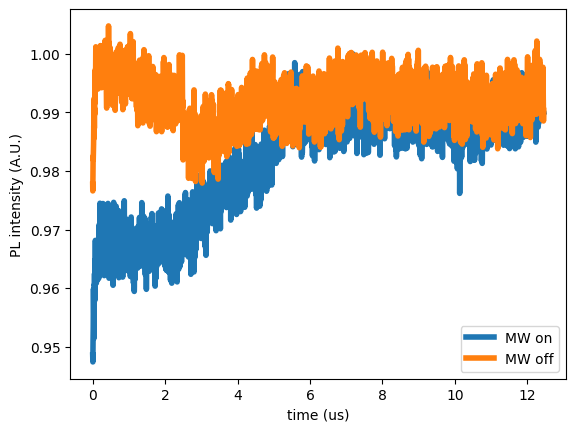

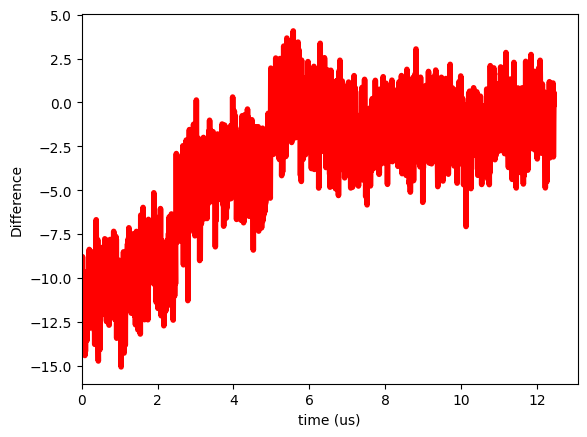

In [ ]:
# Here we plot the readout window data for the microwave pluse on and the microwave off

t = np.array(range(len(data_off))) * min_step_us
x = data_on
x2 = data_off

plt.plot(t, x/np.max(x), linewidth=4)
plt.plot(t, x2/np.max(x), linewidth=4) 

plt.legend(['MW on', 'MW off'])
plt.xlabel('time (us)')
plt.ylabel('PL intensity (A.U.)')
plt.show()

plt.plot(t, x - x2, c='red', linewidth=4)
plt.ylabel('Difference')
plt.xlabel('time (us)')
plt.xlim(0, )
plt.show()


## 4b Fitting the Readout Window Data

After calibrating the laser_readout_offset, we want to find the pumping time from our initial spin state to m<sub>s</sub>=0.  We find this value by fitting the difference between microwave on and microwave off data to an exponential decay.  The extracted time constant tau can then be used to determine our readout_integration_t#, which is 1xtau, and the total laser pumping time which should be at least 5xtau.

[12.89537287  2.87299555  0.60534208]


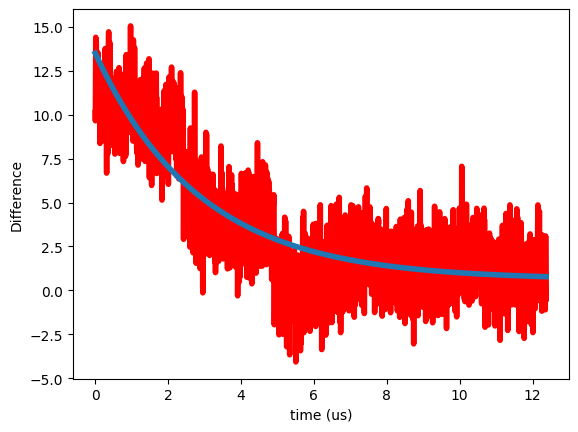

In [ ]:
x = (data_off-data_on)[30:len(data_off-data_on)]
t = np.array(range(len(x)))*min_step_us

plt.plot(t, x, linewidth=4, color='red')
# plt.plot(t, exponential_decay(t, 800, 0.8, 0), linewidth=4, color='red')

param, _ = curve_fit(qd.exponential_decay, t, x, p0=[800, 0.8, 100])

plt.plot(t, qd.exponential_decay(t, *param), linewidth=4)
plt.ylabel('Difference')
plt.xlabel('time (us)')
# plt.xlim(0, )
# plt.ylim(0, )
print(param)

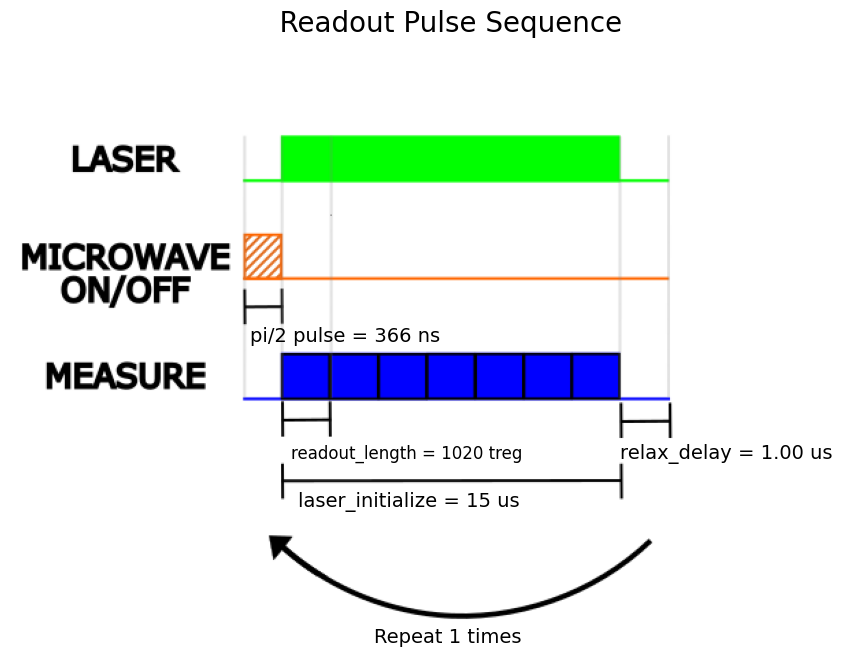

In [ ]:
# Plot Readout Window pulse sequence with config
qd.ReadoutWindow.plot_sequence(config)


# 5 Rabi Oscillations <a class="anchor" id="seventh-bullet"></a>
After calibrating the readout window by getting laser_readout_offset_t# and readout_integration_t#, the last step before pulse sequencing is to calibrate the microwave pi/2 pulse length.  Microwave pi/2 pulse length calibration is determined by a rabi oscialltion pulse sequence where we initilize our spins to ms=0, vary the length of a microwave pulse, and readout the spin projection of our NVs. 

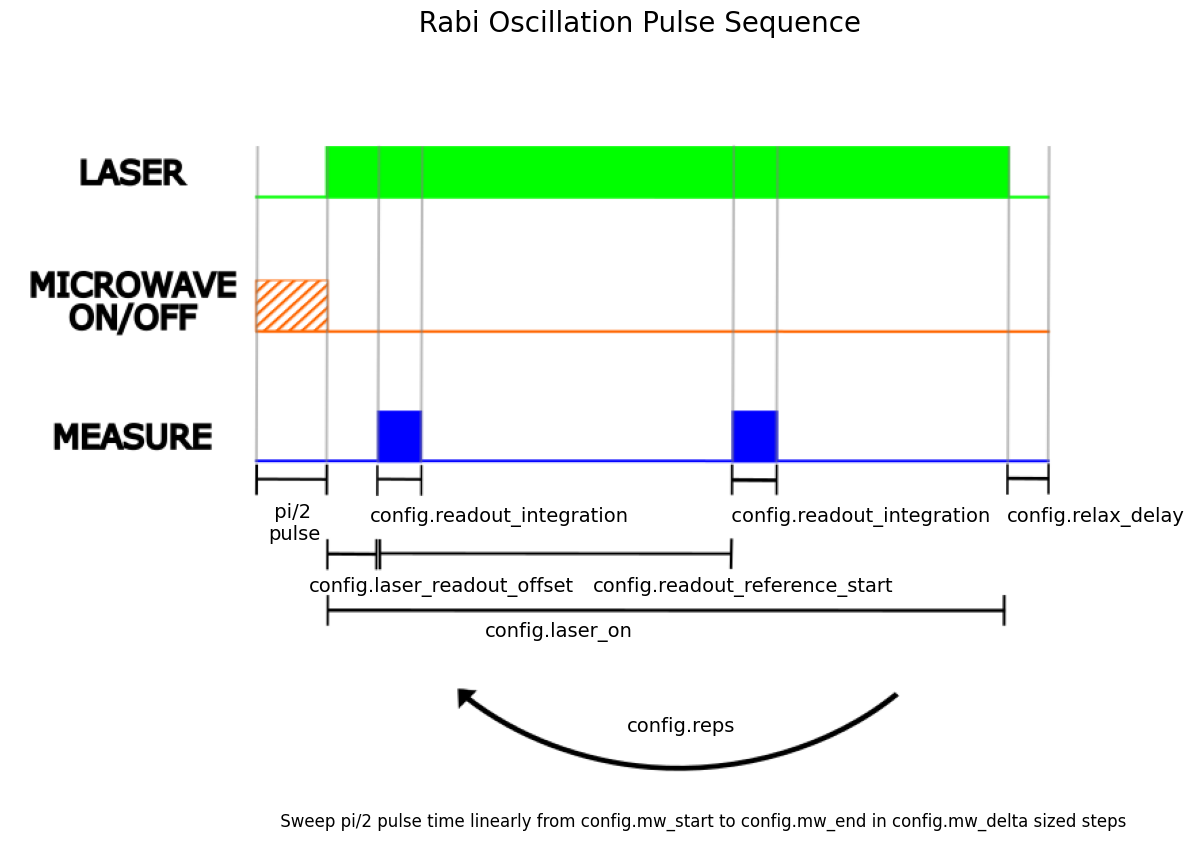

In [ ]:
qd.RabiSweep.plot_sequence()

## 5a. Configuration, Measurment, and Plotting <a class="anchor" id="seventh-bullet"></a>

For our Rabi Oscillations we again copy the default_config and assign some familiar parameters, but also some new ones.  Most specifically we highlight that we have now added:

- add_linear_sweep('mw', 'treg', start=4, stop=800, delta=4) - a helper function that generates the required sweep parameters to change the microwave pulse length from the start value to the end value in steps of delta. 
- .readout_integration_t# - The amount of time to integrate at the beginning of the readout window as our "signal"

In [6]:
config = copy(default_config)

config.relax_delay_tus=1

config.mw_gain = 30000
config.mw_fMHz = 2543

config.pre_init=True

config.relax_delay_tus=15

config.laser_on_tus = 25 # in us
config.readout_integration_tus = 2  # us
config.readout_reference_start_tus = 20 # us

config.laser_readout_offset_treg=310 #
config.mw_readout_delay_treg = 50

config.add_linear_sweep('mw', 'treg', start=4, stop=800, delta=4)

config.reps=1000

prog = qd.RabiSweep(config)
d = prog.acquire(progress=True)


  0%|          | 0/800000 [00:00<?, ?it/s]

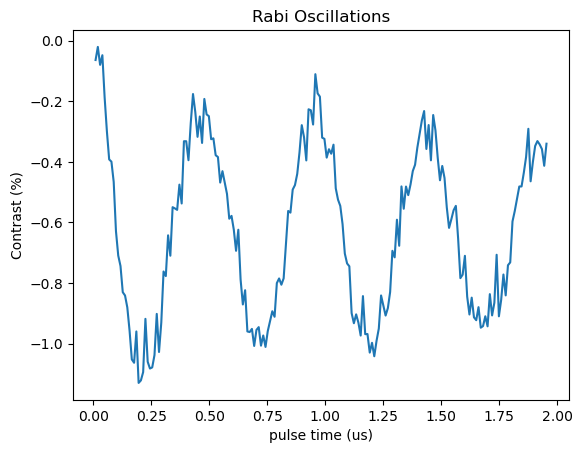

In [7]:
plt.plot(d.sweep_tus, d.contrast)

plt.title('Rabi Oscillations')
plt.ylabel('Contrast (%)')
plt.xlabel('pulse time (us)')
plt.show()


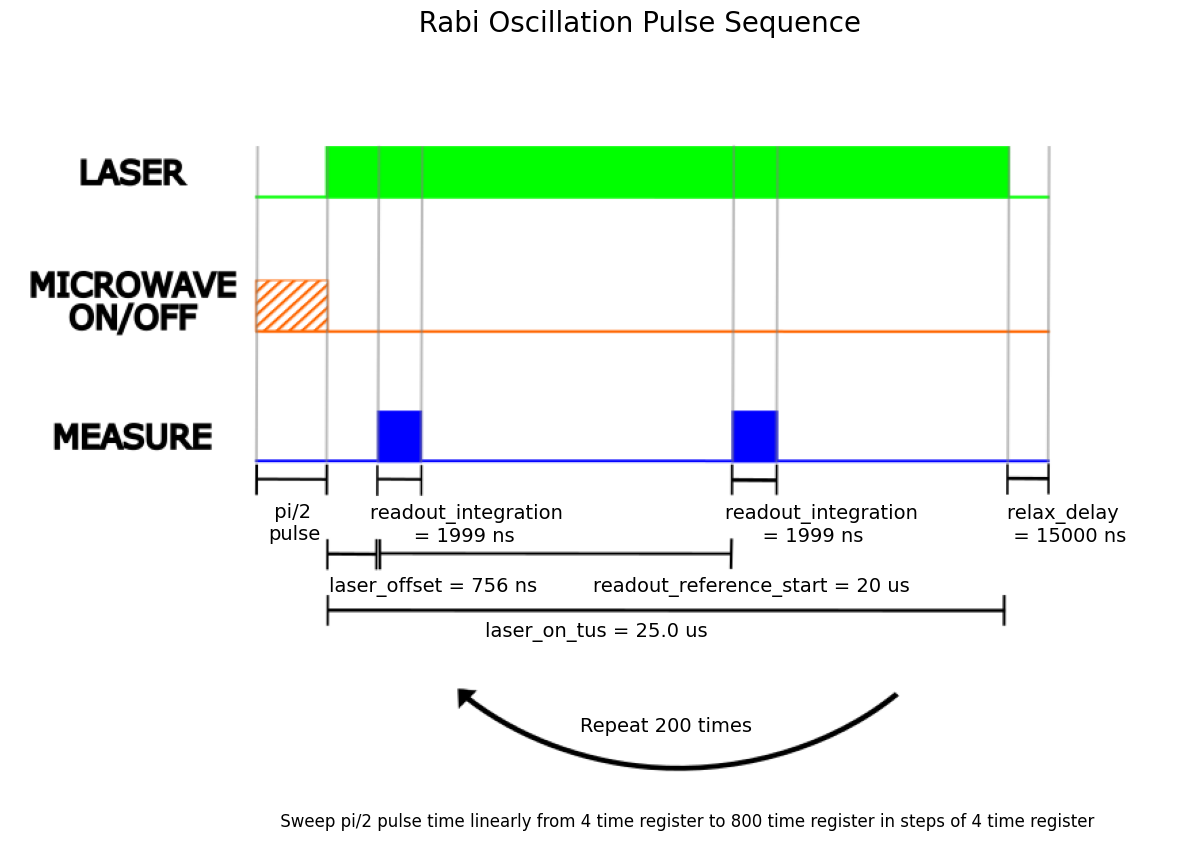

In [ ]:
qd.RabiSweep.plot_sequence(config)


In [ ]:
def decaying_cos(x, A, T, y0, tau):

    return A*(np.cos(x*2*np.pi/T))*np.exp(-x/tau)+y0


Pi/2 pulse is approximately 116 ns


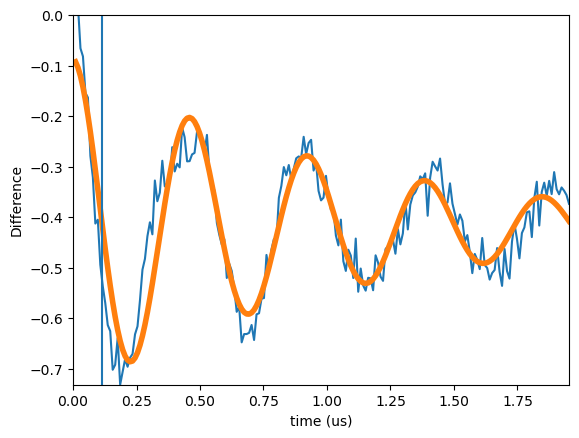

In [ ]:
p0 = [-1, 0.260,-2.5, 0.5]

t = d.sweep_tus
x = d.contrast

param, _ = curve_fit(decaying_cos, t, x, p0 = p0)

plt.plot(d.sweep_tus, d.contrast)

plt.plot(t, decaying_cos(t, *param), linewidth=4)
plt.ylabel('Difference')
plt.xlabel('time (us)')
plt.xlim(0, np.max(t))
plt.ylim(np.min(x), 0)
print('Pi/2 pulse is approximately {:.0f} ns'.format(param[1]*1000/4))
plt.vlines(param[1]/4, np.min(d.contrast), 0)



## 5c. Live Rabi Oscillations

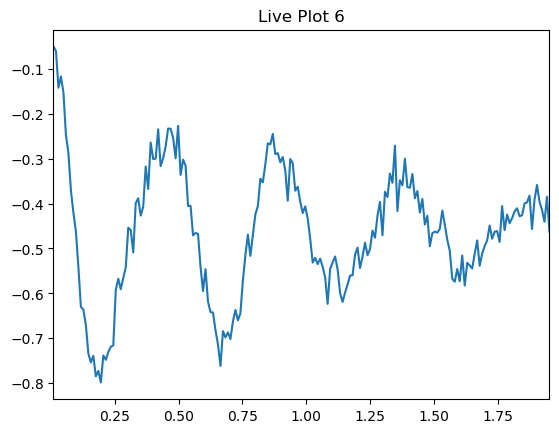

In [ ]:
def get_rabi():
    prog = qd.RabiSweep(config)
    d = prog.acquire(progress=False)

    return d.sweep_tus, d.contrast

qd.live_plot(get_rabi)

# 6 Ramsey <a class="anchor" id="seventh-bullet"></a>
Now that we have the pumping time from our inital spin state to m<sub>s</sub>=0, we want to measure the transition frequency and T2<sup>*</sup>. Specifically, to measure the transition frequency and T2<sup>*</sup> we perform a Ramsey pulse sequence and then use a Real-Valued Fast Fourier Transform (RFFT) to extract the transition frequency from the signal. Ramsey avoids the power broadening of optically detected magnetic resonace (ODMR)) and gives a view of the spectrum given that the pi/2 pulse is sufficeint to excite the whole spectrum.

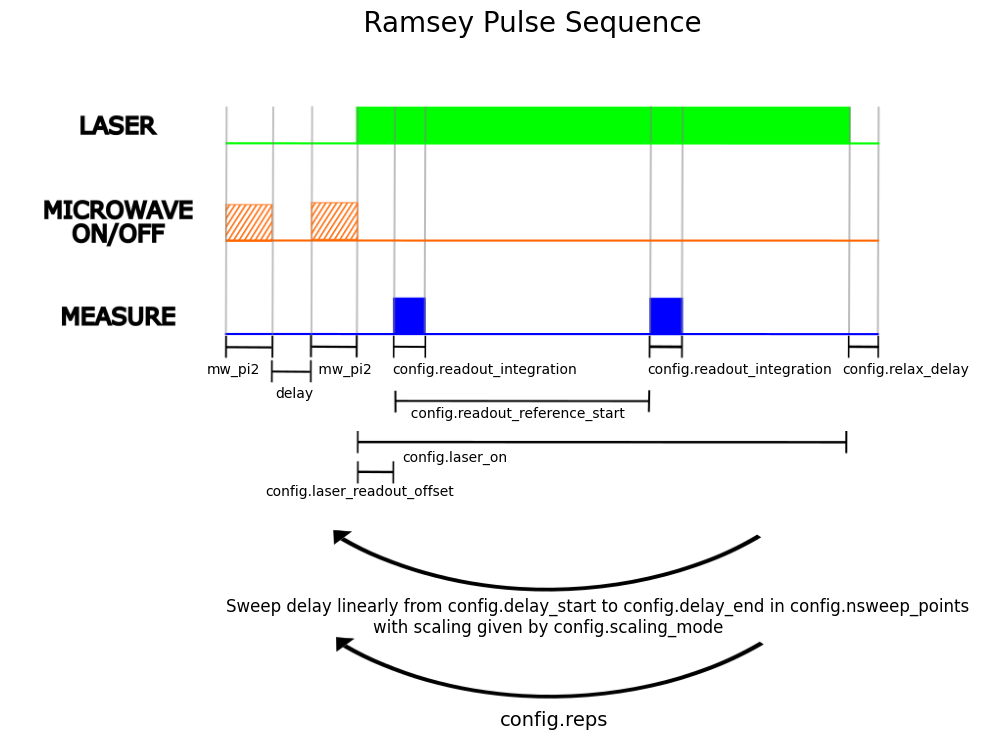

In [ ]:
qd.Ramsey.plot_sequence()

## 6a. Configuration, Measurement, and Plotting
Ramsey pulse sequence adds the following new settings to the configuration:

- .delay_start_t#- ldelay length the sweep begins at 
- .delay_end_t# - delay length the sweep ends at
- .nsweep_points - the number of points in the sweep 



In [8]:
config = copy(default_config)

config.mw_gain = 30000
config.mw_fMHz = 2545 #pulse slightly off resonant frequency
config.mw_pi2_tns = 114

config.readout_delay_treg = 50
config.adc_trigger_offset = 190
config.relax_delay_tus = 15
config.pre_init=True

config.mw_readout_delay_treg = 50 #
config.laser_readout_offset_treg= 310 #
config.laser_on_tus = 25 # in us
config.readout_integration_tus = 1 # us
config.readout_reference_start_tus = 20 # us

#for linear delay sweep
config.delay_start_treg=4
config.delay_end_treg=800
config.nsweep_points=100

config.reps=10000

prog = qd.Ramsey(config)
d = prog.acquire(progress=True)




  0%|          | 0/4000000 [00:00<?, ?it/s]

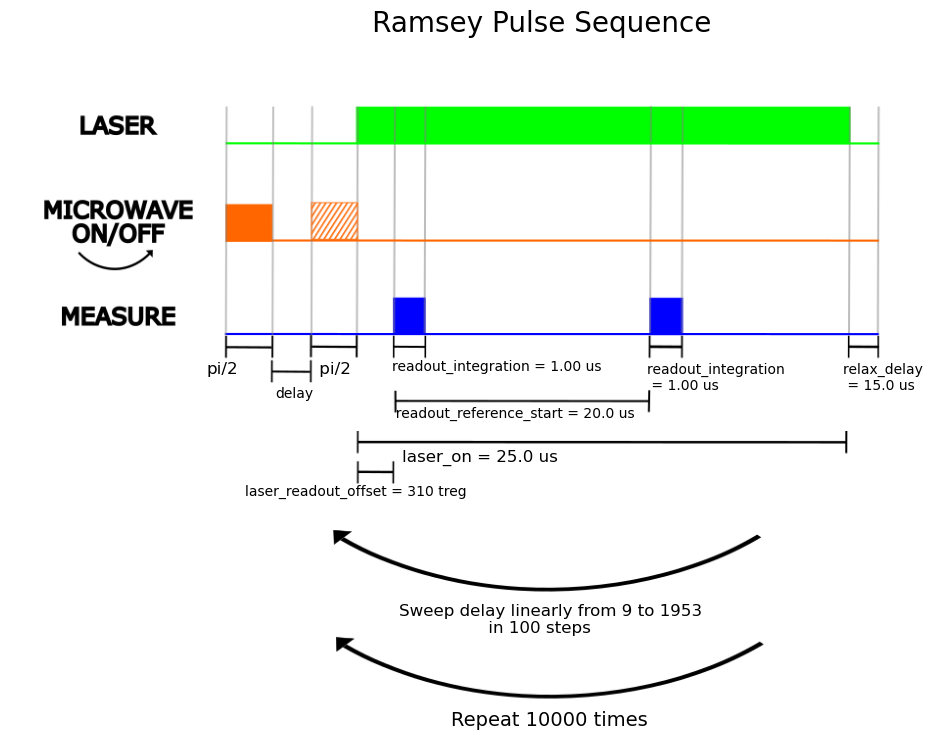

In [9]:
qd.Ramsey.plot_sequence(config)


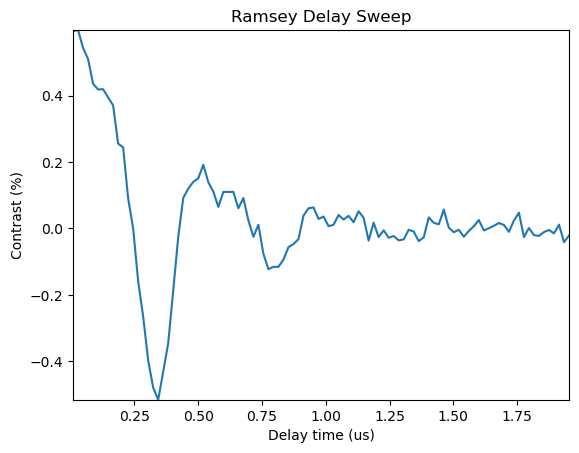

In [10]:

t = d.sweep_tus
x = d.contrast

# param, _ = curve_fit(qd.exponential_decay, t, x, p0 = p0)

plt.plot(t, x)

plt.ylabel('Contrast (%)')
plt.xlabel('Delay time (us)')

plt.xlim(np.min(d.sweep_tus), np.max(d.sweep_tus))
plt.ylim(np.min(d.contrast), np.max(d.contrast))

plt.title('Ramsey Delay Sweep')

plt.show()


## 6b. ODMR Spectrum from Ramsey

Now we use a Real-Valued Fast Fourier Transform (RFFT) to extract the transition frequency from the signal.

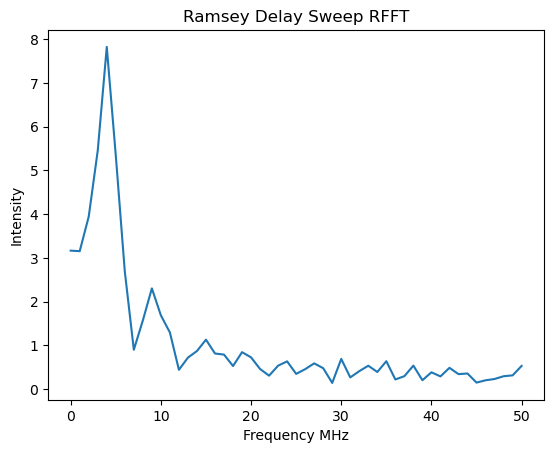

In [11]:
t = d.sweep_tus
x = d.contrast


fs = config.nsweep_points/(config.delay_end_tus-config.delay_start_tus)  # Sampling frequency

# Perform the Fast Fourier Transform (FFT)
fft_result = np.fft.rfft(x)
frequencies_fft = np.fft.rfftfreq(len(fft_result), 1/fs)
plt.ylabel("Intensity")
plt.xlabel("Frequency MHz")
plt.title('Ramsey Delay Sweep RFFT')
plt.plot(np.abs(fft_result))



# 7 Hahn Echo Delay Sweep <a class="anchor" id="eigth-bullet"></a>
With the calibraiton of our pi/2 pulse from our Rabi Oscillation data, we can now move on to measuring properties of our NV enviroment, first, by measuring the Hahn Echo T<sub>2,Hahn</sub>.  In our Hahn echo pulse sequence, we have two pulse sequences and four readouts, just as before.  In the first pulse sequence, we exectue microwave pi/2 - delay - pi - delay - pi/2 followed by our readout window.  In the second pulse sequence, we exectue the microwave sequence pi/2 - delay - pi - delay - pi/2<sub>-x</sub> followd by our readout window. These sequences project the NV spin state on to the -z and +z axes of the Bloch sphere, giving contrast between projected spin states.

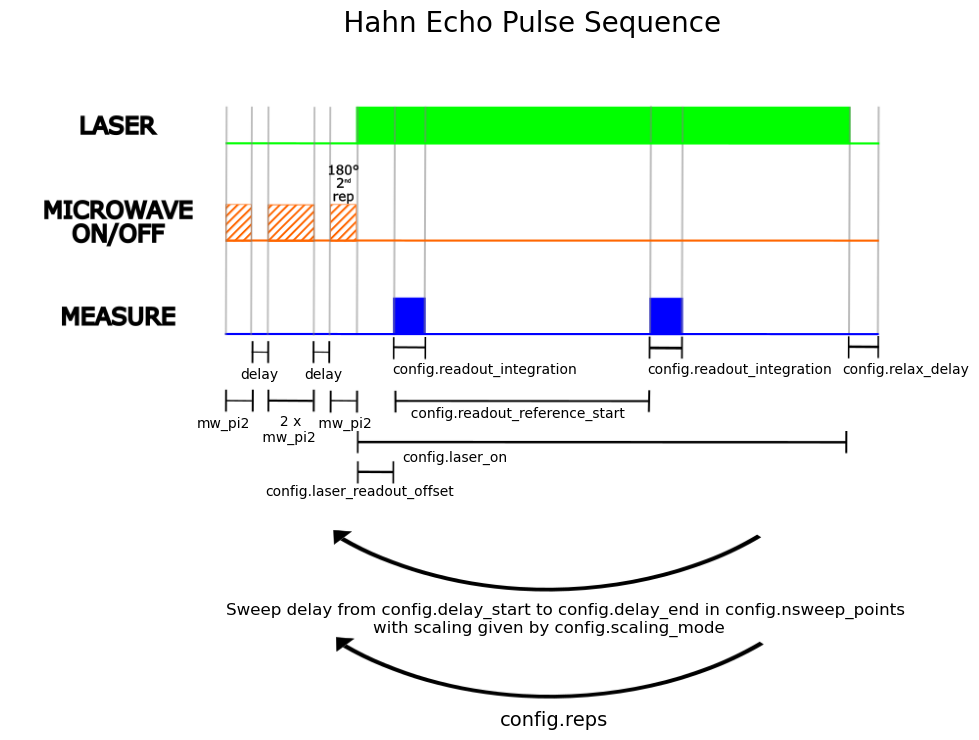

In [ ]:
qd.HahnEchoDelaySweep.plot_sequence()

## 7a. Configuration, Measurement, and Plotting

The configuration attributes for the Hahn Echo T<sub>2</sub> pulse sequence are quite similar to those of the Rabi Oscillations.  The main change here is the addition of sweep parameters that scale exponentially. These are assigned by the NVConfiguration.add_exponential_sweep() method with parameters 
- swept parameter name : 'delay'
- swept parameter unit: 'tus'
- start value : 0.05
- stop value : 50
- scaling_factor : '17/16'

These parameters generate a sweep that changes the delay time (in us) from 0.05 us to 50 us, where the steps are delay<sub>i+1</sub> = 17/16 x delay<sub>i</sub> starting at  0.05 us until the final delay is the first value larger than 50us. The cell below is an example of both how to configure  qd.HahnEchoDelaySweep and acquire the data

In [ ]:
config = copy(default_config)

config.mw_gain = 30000
config.mw_fMHz = 2540
config.mw_pi2_tns = 116

config.readout_delay_treg = 50
config.adc_trigger_offset = 190
config.relax_delay_tus = 15
config.pre_init=True

config.mw_readout_delay_treg = 50 #
config.laser_readout_offset_treg= 310 #
config.laser_on_tus = 25 # in us
config.readout_integration_tus = 1 # us
config.readout_reference_start_tus = 20 # us

config.add_exponential_sweep('delay', 'tus', start=0.05, stop=50, scaling_factor='17/16')

config.reps=10000

prog = qd.HahnEchoDelaySweep(config)
d = prog.acquire(progress=True)


  0%|          | 0/4960000 [00:00<?, ?it/s]

q.HahnEchoDelaySweep.acquire() returns a data object with attributes, sweep_tus, sweep_tns, sweep_treg, singal1, signal2, reference1, reference2, contrast1, contrast2, and contrast.  All of which we have seen before from our qd.RabiOscillation.acquire() method. 

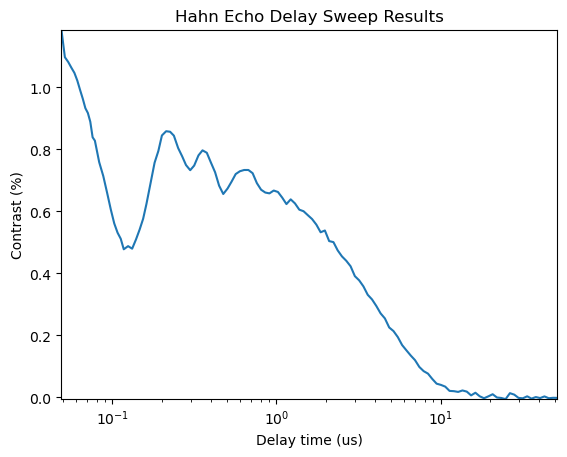

In [ ]:
t = d.sweep_tus
x = d.contrast

# param, _ = curve_fit(qd.exponential_decay, t, x, p0 = p0)

plt.plot(t, x)
plt.xscale('log')

plt.ylabel('Contrast (%)')
plt.xlabel('Delay time (us)')

plt.xlim(np.min(d.sweep_tus), np.max(d.sweep_tus))
plt.ylim(np.min(d.contrast), np.max(d.contrast))

plt.title('Hahn Echo Delay Sweep Results')

plt.show()


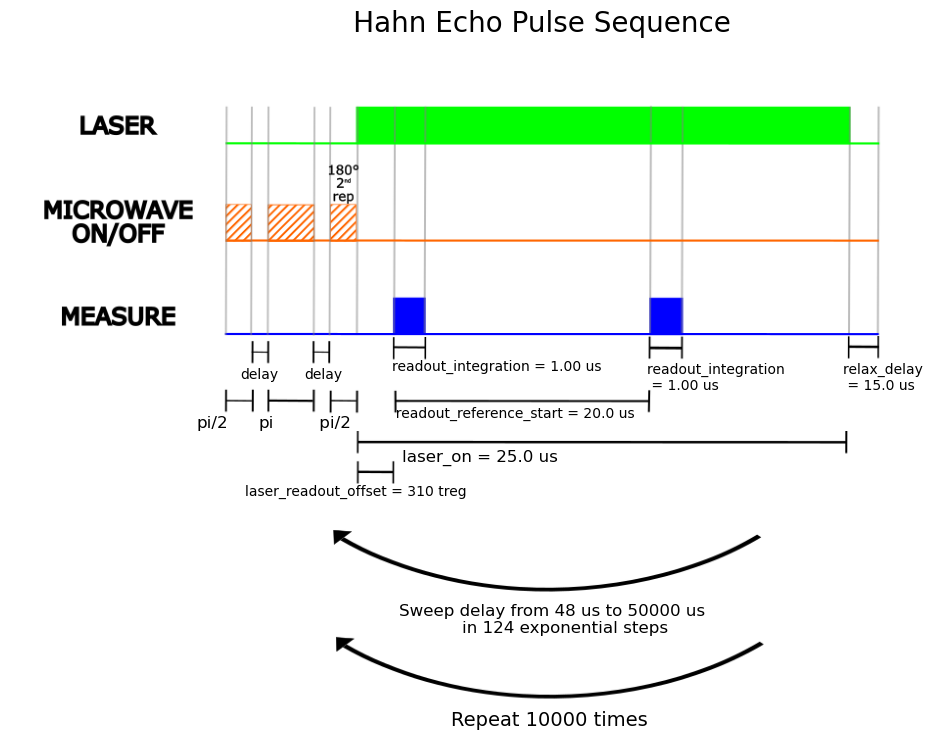

In [ ]:
qd.HahnEchoDelaySweep.plot_sequence(config)

# 8. T<sub>1</sub> Delay Sweep <a class="anchor" id="nineth-bullet"></a>

The spin lattice relaxation time is another fundamental parameter of our NVs that we want to measure either to characterize our NVs or a material of interest close to the NVs. Our T<sub>1</sub> pulse sequence consists of initializing the spins to m<sub>s</sub> = 0, followed by a microwave pulse (or none for referencing) and a variable delay time, then a readout. There are a total of four measurements in this pulse sequence "signal1" at the beginning of the first readout window where have inverted the spins, "reference1" toward the end of the readout window, "signal2" at the beginning of the second readout window where we have not inverted the spins, and "reference2" toward the end of the second readout window. 

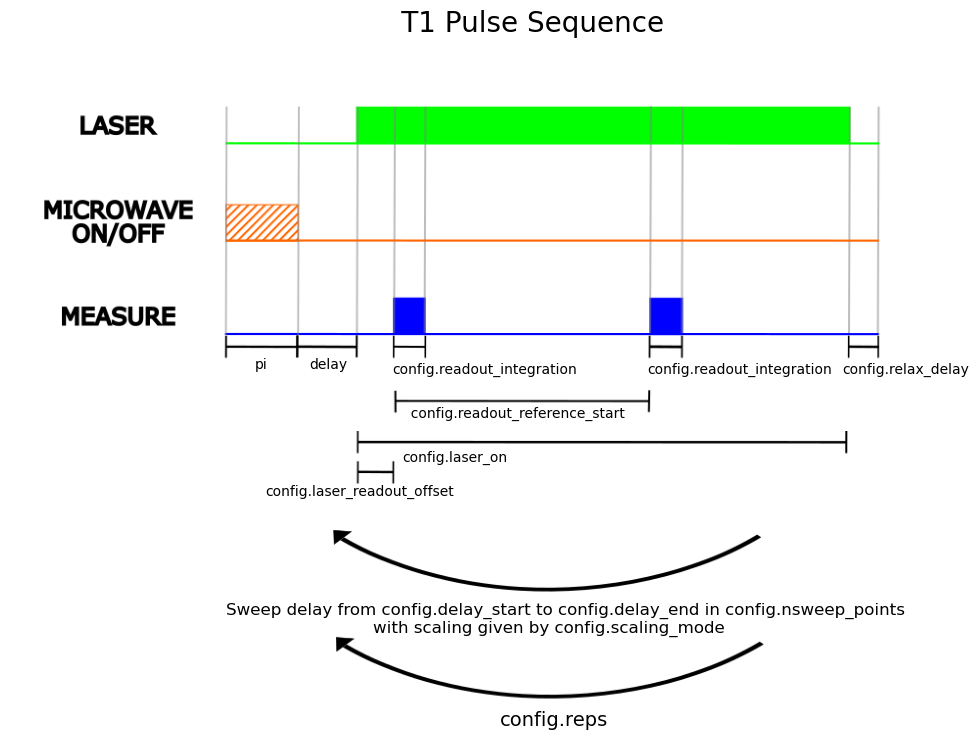

In [ ]:
qd.T1DelaySweep.plot_sequence()

## 8a. Configuration, Measurement, and Plotting

Configuration attributes for qd.T1DelaySweep are identical to that of qd.HahnEchoDelaySweep, however in this example we alter the start, stop and scaling factor of the delay so that we can acquire the full T1 relaxation curve, which can last up to a few ms for NVs at room temperature.  The cell below is an example configuration and acquisition with the T<sub>1</sub> Delay Sweep program

In [ ]:
# exponential scaling

config = copy(default_config)

config.mw_gain = 30000
config.mw_fMHz = 2540
config.mw_pi2_tns = 100

config.laser_readout_offset_treg = 310
config.mw_readout_delay_treg = 50

config.pre_init=True

config.laser_on_tus = 15 # in us
config.readout_integration_tus = 1 # us
config.readout_reference_start_tus = 10 # us

config.add_exponential_sweep('delay', 'tus', start=1, stop=10000, scaling_factor='3/2')

config.reps=1000

prog = qd.T1DelaySweep(config)
d = prog.acquire(progress=True)


  0%|          | 0/96000 [00:00<?, ?it/s]

T1 is approximatel 2.351445 ms


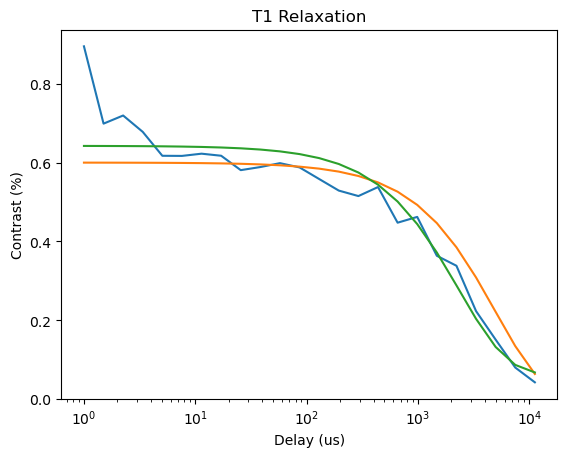

In [ ]:
p0 = [0.6, 5e3, 0]

plt.plot(d.sweep_tus, d.contrast)
plt.plot(d.sweep_tus, qd.exponential_decay(d.sweep_tus, *p0))

param, _ = curve_fit(qd.exponential_decay, d.sweep_tus, d.contrast, p0)
plt.plot(d.sweep_tus, qd.exponential_decay(d.sweep_tus, *param))

plt.xscale('log')
# plt.xlim(1, )
print('T1 is approximatel {:0f} ms'.format(param[1]/1e3))
plt.title('T1 Relaxation')
plt.ylabel('Contrast (%)')
plt.xlabel('Delay (us)')
plt.show()

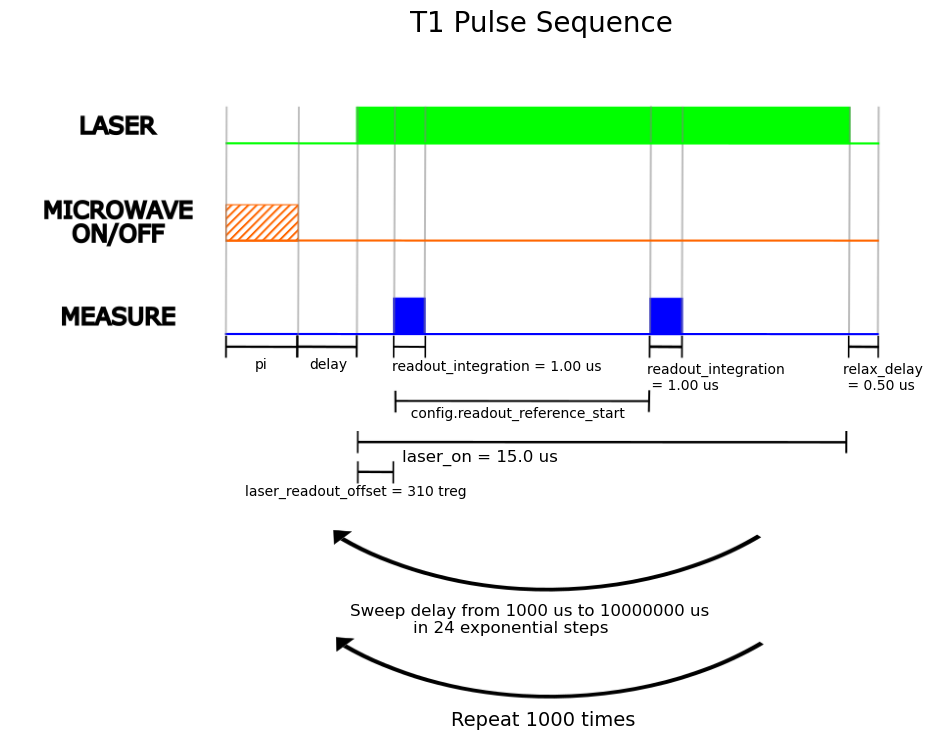

In [ ]:
qd.T1DelaySweep.plot_sequence(config)


As of November 2023, this concludes our Demo Notebook for QICK-DAWG.  We have shown how to configure measurements, collect data, and have demonstrated fundatmental pulse sequences for NV magnetometry.  In the future, we plan on adding
- A program for CPMGXY8-n
- The ability to directly count TTL inputs from a photon counter. 
- and more!